In [1]:
!pip3 install torch torchvision

     |████████████████████████████████| 2.1MB 8.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms  

In [3]:
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

In [4]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()  #creating a copy, detach any existing graphs etc, and convert to numpy
  image = image.transpose(1, 2, 0)  #(1, 28, 28) to (28, 28, 1)
  print(image.shape)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


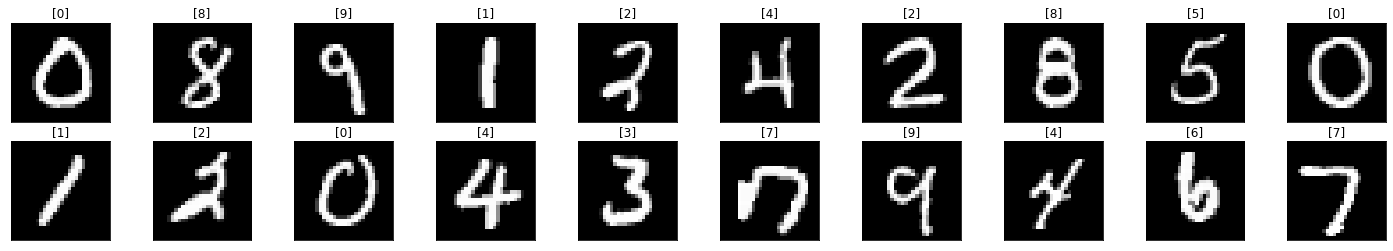

In [5]:
dataiter = iter(training_loader)  #iteration through a batch of images
images, labels = dataiter.next()  #next batch
fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  plt.imshow(im_convert(images[idx]))  #need to convert to np array to display
  ax.set_title([labels[idx].item()])

In [6]:
class Classifier(nn.Module):

  def __init__(self, D_in, H1, H2, D_out):
    super().__init__()
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)

  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x    #here we return the raw score , since we use nn.CrossEntropyLoss which is logsoftmax + Negative log likelihood - Value should not be close to 0 or 1 for log


In [7]:
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [9]:
# epochs = 15
# running_loss_history = []
# running_corrects_history = []
# val_running_loss_history = []
# val_running_corrects_history = []

# for e in range(epochs):
  
#   running_loss = 0.0
#   running_corrects = 0.0
#   val_running_loss = 0.0
#   val_running_corrects = 0.0
  
#   for inputs, labels in training_loader:
#     inputs = inputs.view(inputs.shape[0], -1)
#     outputs = model(inputs)
#     loss = criterion(outputs, labels)
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     _, preds = torch.max(outputs, 1)
#     running_loss += loss.item()
#     running_corrects += torch.sum(preds == labels.data)

#   else:
#     with torch.no_grad():
#       for val_inputs, val_labels in validation_loader:
#         val_inputs = val_inputs.view(val_inputs.shape[0], -1)
#         val_outputs = model(val_inputs)
#         val_loss = criterion(val_outputs, val_labels)
        
#         _, val_preds = torch.max(val_outputs, 1)
#         val_running_loss += val_loss.item()
#         val_running_corrects += torch.sum(val_preds == val_labels.data)
      
#     epoch_loss = running_loss/len(training_loader)
#     epoch_acc = running_corrects.float()/ len(training_loader)
#     running_loss_history.append(epoch_loss)
#     running_corrects_history.append(epoch_acc)
    
#     val_epoch_loss = val_running_loss/len(validation_loader)
#     val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
#     val_running_loss_history.append(val_epoch_loss)
#     val_running_corrects_history.append(val_epoch_acc)
#     print('epoch :', (e+1))
#     print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
#     print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

In [10]:
epochs = 12
running_loss_history = []
running_corrects_history = []
running_val_loss_history = []
running_val_corrects_history = []

for e in range(epochs):

  running_loss = 0.
  running_corrects = 0. 
  running_val_loss = 0.
  running_val_corrects = 0.

  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)  #1st return value is the winning class score and preds is the winning class, stores in tensors for the data in current batch
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)   #the == returns in form [0, 1, 0, ...] where 1 is if the correct class is predicted, sum of all correct classes

  else:
      with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.view(val_inputs.shape[0], -1)
          val_outputs = model(val_inputs)
          val_loss = criterion(val_outputs, val_labels)

          _, val_preds = torch.max(val_outputs, 1)
          running_val_loss += val_loss.item()
          running_val_corrects += torch.sum(val_preds == val_labels.data)

      val_epoch_loss = running_val_loss / len(validation_loader)
      val_epoch_acc = running_val_corrects.float() / len(validation_loader)
      running_val_loss_history.append(val_epoch_loss)
      running_val_corrects_history.append(val_epoch_acc)    

      epoch_loss = running_loss / len(training_loader)
      epoch_acc = running_corrects.float() / len(training_loader)
      running_loss_history.append(epoch_loss)
      running_corrects_history.append(epoch_acc)

      print("Epoch: {}".format(e))
      print("Training Loss : {:.4}, Acc : {:.4}".format(epoch_loss, epoch_acc.item()))
      print("Validation Loss : {:.4}, Acc : {:.4}".format(val_epoch_loss, val_epoch_acc.item()))

Epoch: 0
Training Loss : 0.9243, Acc : 77.98
Validation Loss : 0.4137, Acc : 88.76
Epoch: 1
Training Loss : 0.3716, Acc : 89.56
Validation Loss : 0.3169, Acc : 90.72
Epoch: 2
Training Loss : 0.3128, Acc : 90.99
Validation Loss : 0.2806, Acc : 91.98
Epoch: 3
Training Loss : 0.281, Acc : 91.82
Validation Loss : 0.2605, Acc : 92.65
Epoch: 4
Training Loss : 0.2561, Acc : 92.58
Validation Loss : 0.2413, Acc : 92.9
Epoch: 5
Training Loss : 0.2362, Acc : 93.14
Validation Loss : 0.2252, Acc : 93.43
Epoch: 6
Training Loss : 0.2189, Acc : 93.64
Validation Loss : 0.2094, Acc : 93.72
Epoch: 7
Training Loss : 0.2022, Acc : 94.18
Validation Loss : 0.1975, Acc : 93.99
Epoch: 8
Training Loss : 0.1893, Acc : 94.41
Validation Loss : 0.1837, Acc : 94.51
Epoch: 9
Training Loss : 0.1771, Acc : 94.8
Validation Loss : 0.1719, Acc : 94.78
Epoch: 10
Training Loss : 0.1663, Acc : 95.14
Validation Loss : 0.1682, Acc : 94.96
Epoch: 11
Training Loss : 0.1561, Acc : 95.42
Validation Loss : 0.1599, Acc : 95.18


In [11]:
# epochs = 12
# running_loss_history = []
# running_corrects_history = []

# for e in range(epochs):

#   running_loss = 0.
#   running_corrects = 0. 

#   for inputs, labels in training_loader:
#     inputs = inputs.view(inputs.shape[0], -1)
#     outputs = model(inputs)
#     loss = criterion(outputs, labels)

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     _, preds = torch.max(outputs, 1)  #1st return value is the winning class score and preds is the winning class, stores in tensors for the data in current batch
#     running_loss += loss.item()
#     running_corrects += torch.sum(preds == labels.data)   #the == returns in form [0, 1, 0, ...] where 1 is if the correct class is predicted, sum of all correct classes

#   else:
#       epoch_loss = running_loss / len(training_loader)
#       epoch_acc = running_corrects.float() / len(training_loader)
#       running_loss_history.append(epoch_loss)
#       running_corrects_history.append(epoch_acc)
#       print("Training Loss : {:.4}, Acc : {:.4}".format(epoch_loss, epoch_acc.item()))

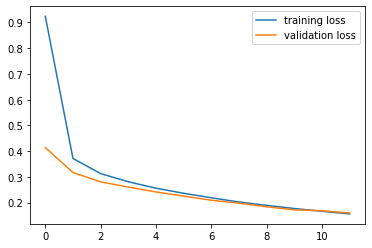

In [13]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(running_val_loss_history, label = 'validation loss')
plt.legend()

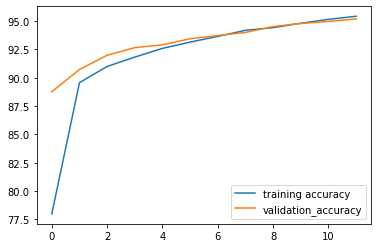

In [14]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(running_val_corrects_history, label = 'validation_accuracy')
plt.legend()

In [15]:
!pip3 install pillow==4.0.0

  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.6.0+cu101 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [16]:
import PIL.ImageOps

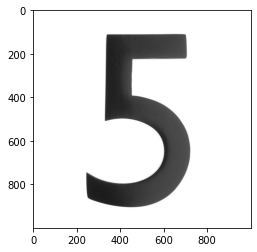

In [17]:
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

(28, 28, 1)


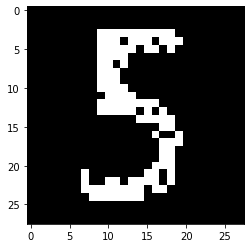

In [18]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [20]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print(pred.item())

5


(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


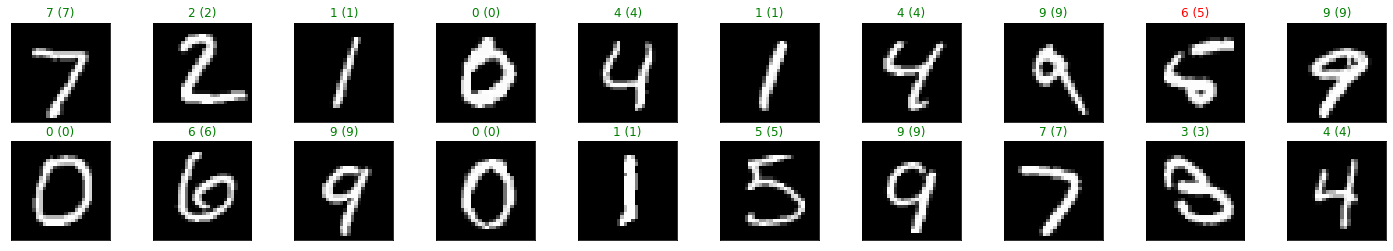

In [26]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
outputs = model(images_)
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color = ("green" if preds[idx] == labels[idx] else "red"))
